<a href="https://colab.research.google.com/github/o-b-one/face-recognition-similarity/blob/main/Face_recognition_similarity_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environment Preparation
- Package installation
- Common import

In [9]:
! pip install DeepFace opencv-python  opencv-python-headless  ffmpeg-python  retina-face faiss-gpu pandas scikit-learn

In [10]:
from typing import Iterator, List, Tuple, Dict, Union, Iterable
import numpy as np
import numpy.typing as npt
import cv2

# Dataset preperation

Please upload your [`kaggle.json`](https://www.kaggle.com/docs/api) to load the dataset



In [4]:
! pip install -q kaggle

In [5]:
import os
check = 'y'
while not os.path.isfile('kaggle.json') and check.lower() != 'n' :
  print('Please upload a valid kaggle.json file to the root folder ("/content")')
  check = input("Check again?(y/n)")

In [6]:
! mkdir -p ~/.kaggle
! cp ./kaggle.json ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json

In [7]:
! kaggle datasets download -d vishesh1412/celebrity-face-image-dataset
! echo N | unzip celebrity-face-image-dataset.zip > /dev/null

100% 52.9M/52.9M [00:01<00:00, 38.1MB/s]
100% 52.9M/52.9M [00:01<00:00, 32.9MB/s]


In [8]:
from os import listdir
from os.path import isfile, join
base_path = "/content/Celebrity Faces Dataset"
few_shot_count = 3

def get_files_per_label(is_train: bool) -> Dict[str, List[str]]:
  labels = {}

  for label in listdir(base_path):
    path = join(base_path, label)
    dir_content = listdir(path)
    dir_content.sort()
    files = [join(base_path, label, pic) for pic in dir_content]

    start = 0 if is_train else few_shot_count
    end = few_shot_count if is_train else -1

    labels[label] = files[start:end]

  return labels

# Helper methods
- `read_image(path: str)` - read image from page and return image object
- `normalize_image(image_data: npt.ArrayLike)` - Get image matrix represnetation, return standarize image in 224X224X3
- `extract_faces(img: npt.ArrayLike)` - Extract face embaddings, landmarks and sizes

In [11]:
models = (
  "VGG-Face",
  "OpenFace",
  "DeepFace",
  "DeepID",
  "ArcFace"
)

In [52]:
from PIL import Image

def read_image(path: str):
  image = cv2.imread(path, cv2.IMREAD_COLOR)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  return np.asarray(image)


In [53]:

DIMENSIONS = (224, 224)
def normalize_image(image_data: npt.ArrayLike):
  image = cv2.resize(image_data, DIMENSIONS)
  return image

In [54]:
from deepface import DeepFace
def extract_embeddings(img: npt.ArrayLike, model: str):
  faces = DeepFace.represent(
            img,
            model_name=model,
            enforce_detection=False,
            detector_backend = "retinaface"
    )

  return faces[0].get('embedding')

In [64]:
def extract_face(img: npt.ArrayLike) -> npt.ArrayLike:
  face = DeepFace.extract_faces(
            img,
            align=True,
            detector_backend = "retinaface"
    )[0]['face']
  return cv2.cvtColor(face, cv2.COLOR_BGR2RGB)

# Preprocssing pipeline
1. Read image from a path
2. Normalize image to the required shape
3. Extract faces embeddings

In [56]:
def preprocessing(path: str, model: str) -> List[npt.ArrayLike]:
    img = read_image(path)
    img_as_matrix = normalize_image(img)
    embeddings = extract_embeddings(img_as_matrix, model=model)
    return embeddings


# Data Preperation

In [57]:
labels_dict = get_files_per_label(is_train=False)

In [58]:
data = []
for label in labels_dict:
  for path in labels_dict[label]:
    data.append((label, path))


In [59]:
import pandas as pd

df = pd.DataFrame(data, columns=['label', 'path'])

In [60]:
img = read_image(df['path'][0])

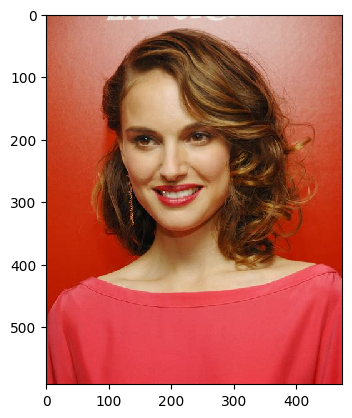

In [61]:
from matplotlib import pyplot as plt
plt.imshow(img, interpolation='nearest')
plt.show()

In [65]:
face = extract_face(img)

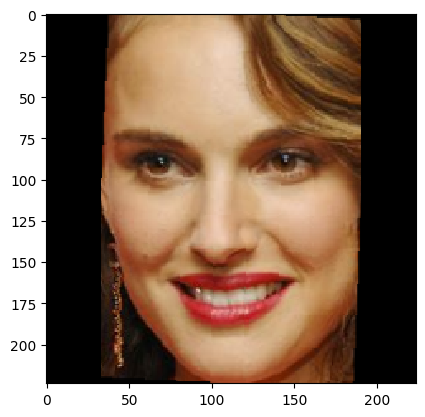

In [66]:
plt.imshow(face, interpolation='nearest')
plt.show()

In [67]:
img = normalize_image(face)

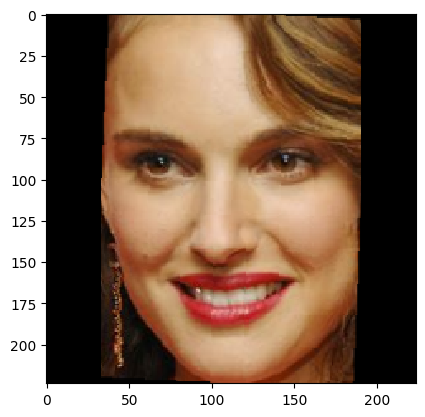

In [68]:
plt.imshow(img, interpolation='nearest')
plt.show()

In [69]:
df['embedding'] = df['path'].apply(lambda path: preprocessing(path, model=models[0]))

# Data Presentation

In [70]:
X = df['embedding'].apply(lambda e: np.asarray(e).reshape(2622))

In [71]:
X = np.asarray([np.asarray(x) for x in np.asarray(df['embedding'])])
X.shape

(1732, 2622)

In [72]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
pca.fit(X)
pca_features_3d = pca.transform(X)

In [73]:
pca = PCA(n_components=2)
pca.fit(X)
pca_features_2d = pca.transform(X)

In [74]:
df_2_component = pd.DataFrame(pca_features_2d, df['label'], ['comp 1', 'comp 2'])

In [75]:
df_3_component = pd.DataFrame(pca_features_3d, df['label'], ['comp 1', 'comp 2', 'comp 3'])

In [76]:
labels = np.unique(df['label'])

In [77]:
import seaborn as sns
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [78]:
palette = [*sns.color_palette("bright").as_hex(), *sns.color_palette("dark").as_hex()]

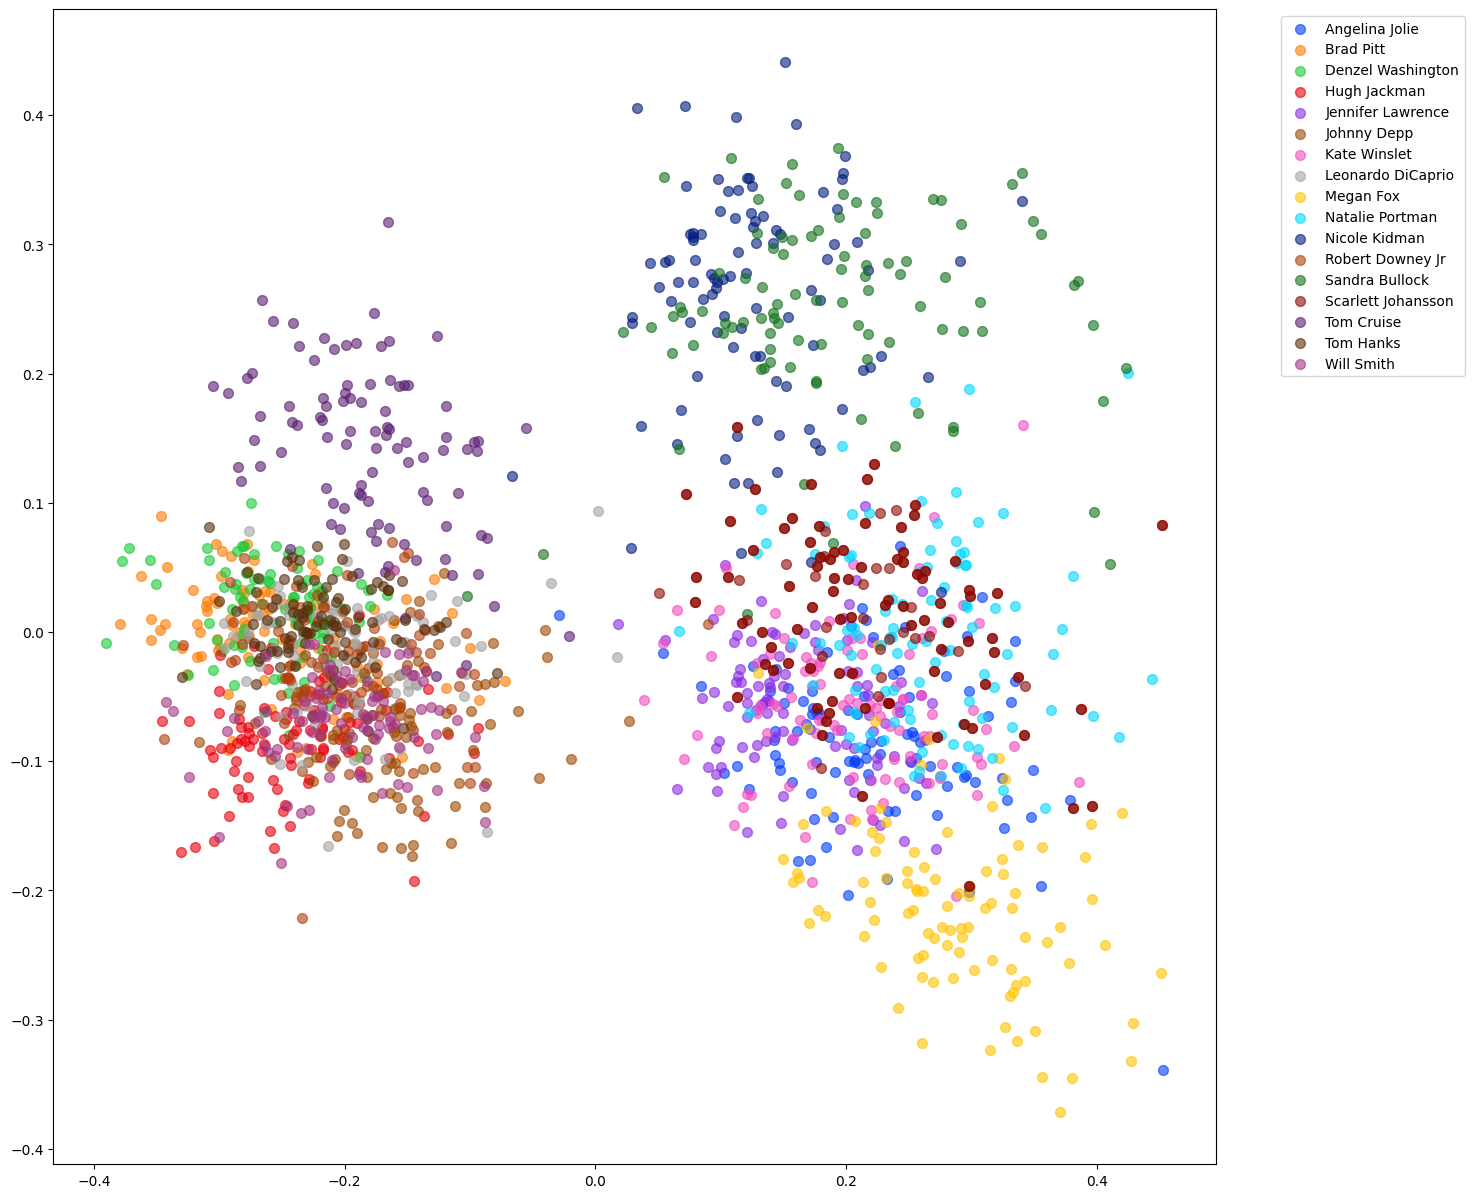

In [79]:
fig = plt.figure(figsize=(15, 15))

for label, color in zip(labels, palette):
    label_df = df_2_component.filter(like=label, axis=0)
    plt.scatter(
        label_df['comp 1'],
        label_df['comp 2'],
        s = 50,
        marker = 'o',
        color = color,
        alpha = 0.6,
        label = label
    )

plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.show()

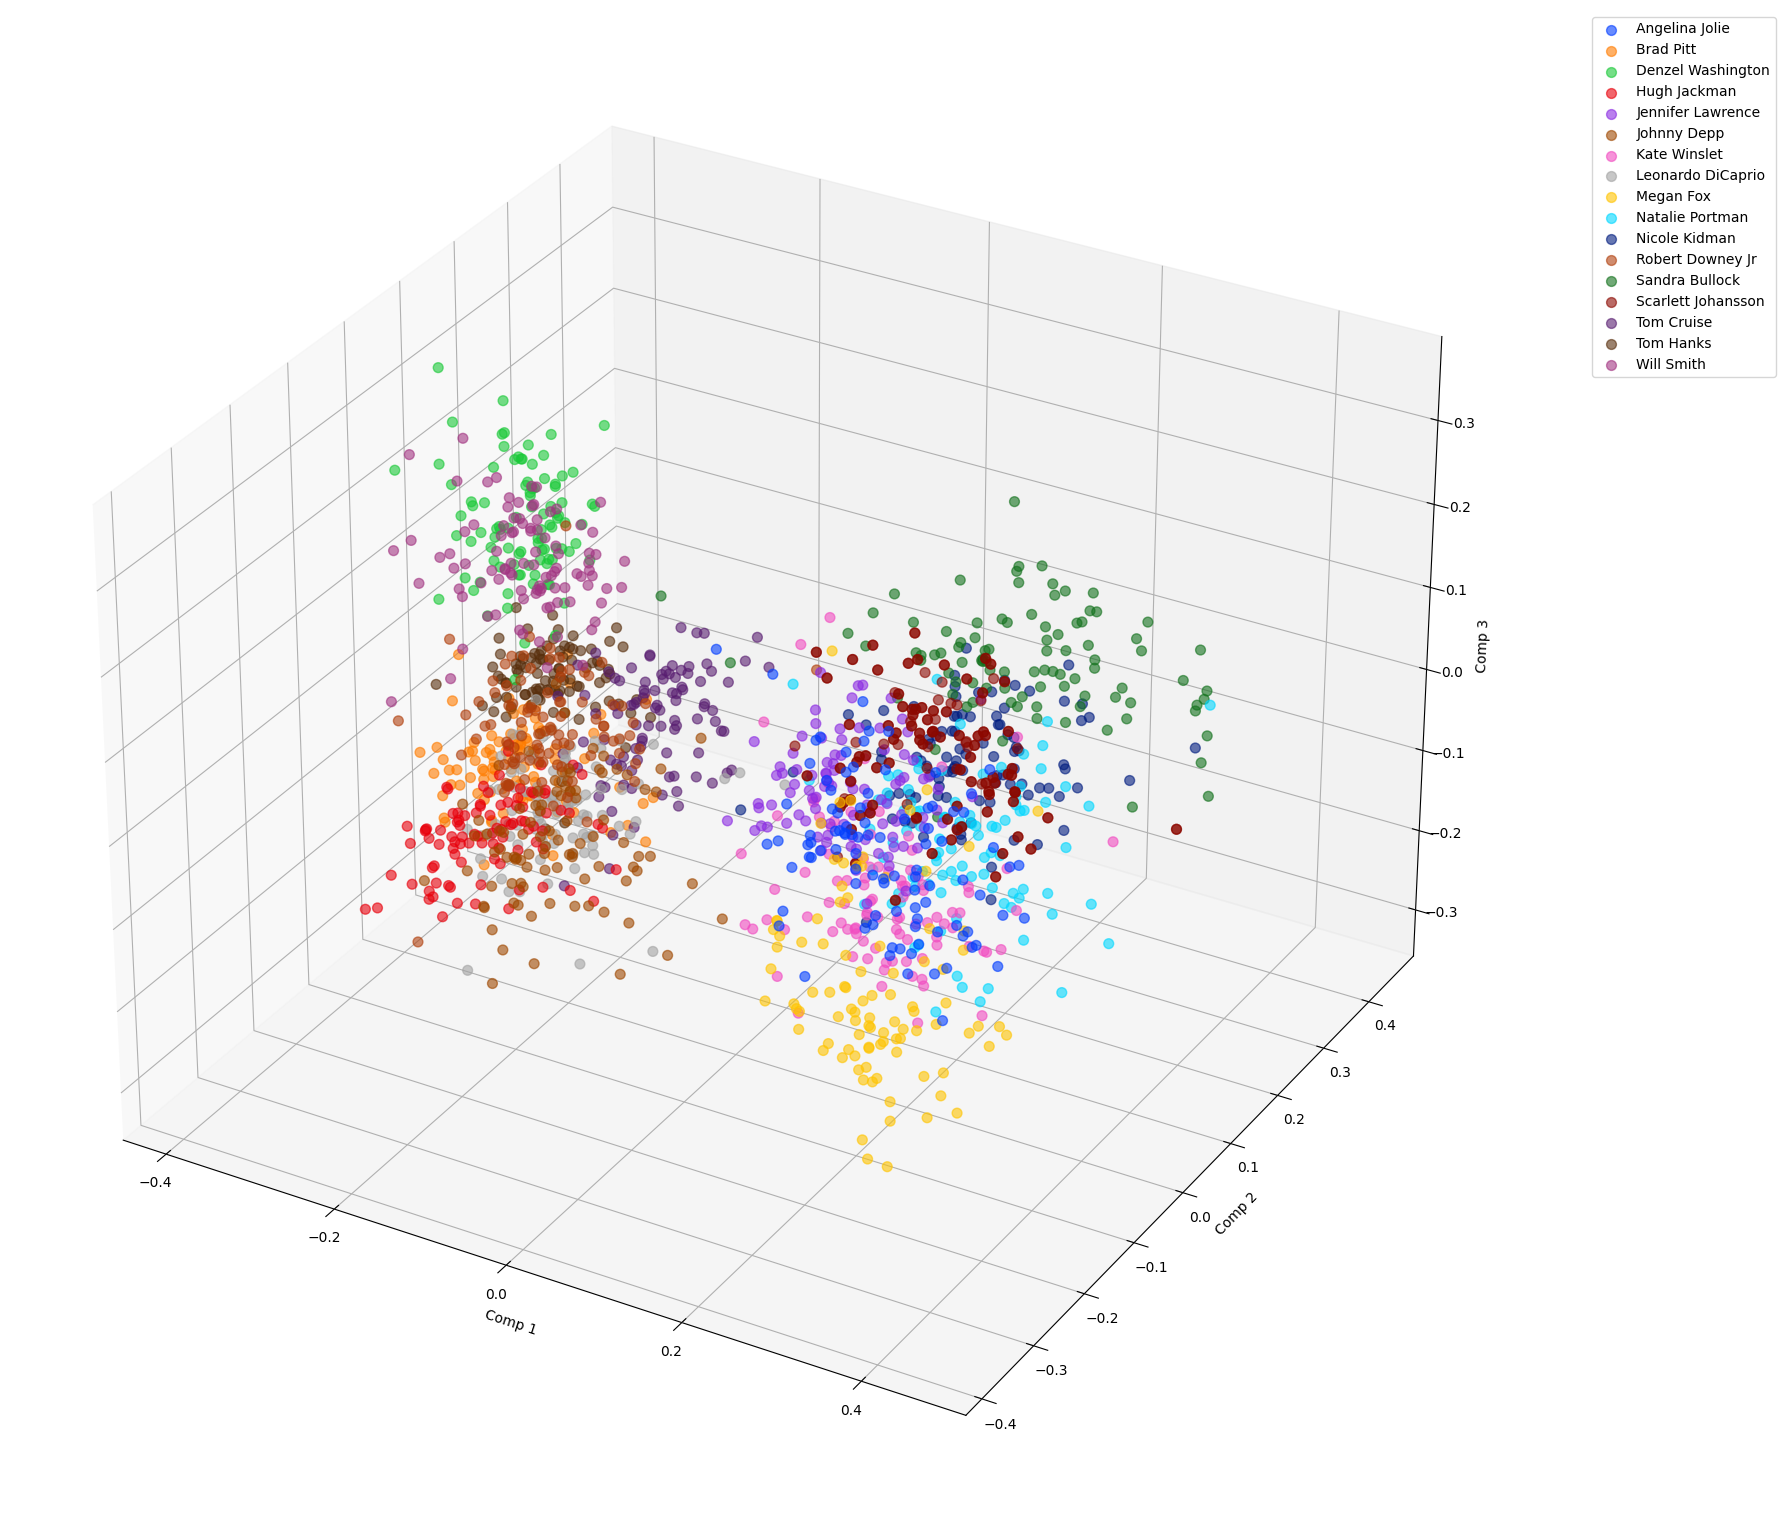

In [80]:
fig = plt.figure(figsize=(15, 15))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)

for label, color in zip(labels, palette):
    label_df = df_3_component.filter(like=label, axis=0)
    ax.scatter(
        label_df['comp 1'],
        label_df['comp 2'],
        label_df['comp 3'],
        s = 50,
        marker = 'o',
        color = color,
        alpha = 0.6,
        label = label
    )

ax.set_xlabel('Comp 1')
ax.set_ylabel('Comp 2')
ax.set_zlabel('Comp 3')

# legend
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.show()

# Create Faiss index with ids

In [86]:
import faiss
indexes = {}

def index_data(embeddings: Iterator[float], id: int, model: str):
    if model not in indexes:
      indexes[model] = faiss.IndexIDMap(faiss.IndexFlatIP(len(embeddings)))
    index = indexes[model]
    normalized_embeddings = np.array(embeddings, dtype=np.float32).reshape(1, -1)
    faiss.normalize_L2(normalized_embeddings)
    index.add_with_ids(normalized_embeddings, np.array([id]))

In [87]:
def search(embaddings: Iterator[float], model: str, thrashold: float = 0, k: int = 0 ) -> Tuple[int, float]:
    normalized_embeddings = np.array(embaddings, dtype=np.float32).reshape(1, -1)
    faiss.normalize_L2(normalized_embeddings)
    index = indexes[model]
    if k:
      score, ids = index.search(normalized_embeddings, k=k)
      score = list(score[0])
      ids = list(ids[0])
    else:
      score, distance, indicies  = index.range_search(normalized_embeddings, thrashold)
      ids = list(map(int, indicies[score[0]:score[-1]]))
      score = list(distance[score[0]:score[-1]])
    return ids, score

# Training

In [88]:
id_counter = 1
ids = {}
for label, files in get_files_per_label(is_train=True).items():
  for file_path in files:
    for model in models:
      embeddings = preprocessing(file_path, model=model)
      if not embeddings:
        print("no faces for", file_path)
        continue
      if label not in ids:
        ids[label] = id_counter
        id_counter += 1
        # print(len(faces[0]))
      index_data(embeddings, ids[label], model=model)

openface_weights.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/openface_weights.h5
To: /root/.deepface/weights/openface_weights.h5
100%|██████████| 15.3M/15.3M [00:00<00:00, 59.6MB/s]


VGGFace2_DeepFace_weights_val-0.9034.h5 will be downloaded...


Downloading...
From: https://github.com/swghosh/DeepFace/releases/download/weights-vggface2-2d-aligned/VGGFace2_DeepFace_weights_val-0.9034.h5.zip
To: /root/.deepface/weights/VGGFace2_DeepFace_weights_val-0.9034.h5.zip
100%|██████████| 511M/511M [00:09<00:00, 53.7MB/s]


deepid_keras_weights.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/deepid_keras_weights.h5
To: /root/.deepface/weights/deepid_keras_weights.h5
100%|██████████| 1.61M/1.61M [00:00<00:00, 53.6MB/s]


arcface_weights.h5  will be downloaded to  /root/.deepface/weights/arcface_weights.h5


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/arcface_weights.h5
To: /root/.deepface/weights/arcface_weights.h5
100%|██████████| 137M/137M [00:02<00:00, 54.1MB/s]


# Evaluation

In [89]:
def evaluate(k:int = None, thrashold: float = None) -> List[Dict]:
  results = []
  for label, files in get_files_per_label(is_train=False).items():
    for file_path in files:
      for model in models:
        real_id = ids.get(label, 0)
        try:
          face = preprocessing(file_path, model=model)
        except:
          continue
        options, score = search(face, model=model, thrashold=thrashold, k=k)
        if not score:
          results.append({
              'score': 0,
              'model': model,
              'real_id': real_id,
              'predicted_id': -1
          })
          continue
        max_arg = np.array(score).argmax()

        predicated_id = options[max_arg]
        for label in ids:
          if ids[label] == predicated_id:
            break

        results.append({
            'score': score[max_arg],
            'model': model,
            'predicted_id': predicated_id,
            'real_id': real_id,
        })
  return results

In [90]:
k = 3
evaluation_dict = evaluate(k=k)

In [91]:
k_df = pd.DataFrame.from_dict(evaluation_dict)


In [92]:
k_df.describe()

,score,predicted_id,real_id
count,8660.000000,8660.000000,8660.000000
mean,0.804190,8.579446,8.578753
std,0.148758,4.787436,4.787231
min,0.131174,1.000000,1.000000
25%,0.739957,4.000000,4.000000
50%,0.838507,8.000000,8.000000
75%,0.902624,13.000000,13.000000
max,1.000001,17.000000,17.000000


# Results evaluation

We will focus on the following scores:
- Recall - As we want to evaluate the ratio of succeessful identification (identifications with a result). In other words - What is the rate for succeful identification (prediction was not missed)?
- Precision - As we want to evaluate the ratio of corrected identification. In other words - how many times the model identify the right persona?
- F1 - Give more weight to false positive and false negatives cases. Help us to measure the balance between Precision and recall.

In [93]:
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, classification_report, accuracy_score
def plot(df: pd.DataFrame) -> None:
  average_type = "macro" # All labels has the same weight
  metrics = []

  for model in models:
    precision, recall, f1, _ = precision_recall_fscore_support(
        df[df['model'] == model]['real_id'],
        df[df['model'] == model]['predicted_id'],
        beta=1,
        average=average_type,
    )
    metrics.append({
      'Recall': recall,
      'Precision': precision,
      'F1': f1,
      'Model': model
    })
  metrics_df = pd.DataFrame(metrics, index=models)
  metrics_df.plot(kind='bar', title='Precision, Recall and F1 comparision cross models')

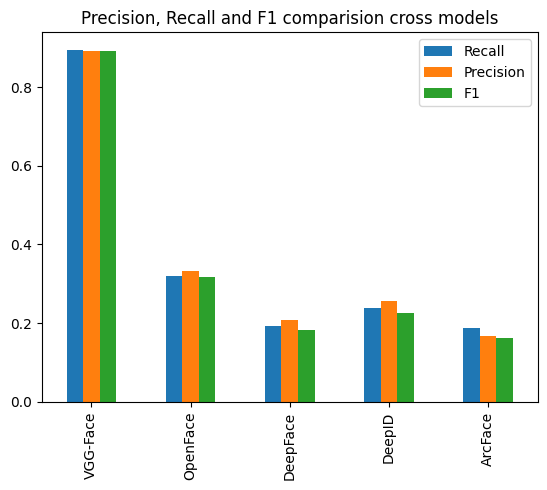

In [94]:
plot(k_df)